In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erf

In [2]:



def get_n(F):
    return np.sum(F * xi_cell_size, axis=(1, 2, 3))

def get_u1(F, n):
    return xi @ np.sum(F * xi_cell_size, axis=(2, 3)).T / n

def get_T(F, n, u):
    return 2 * (np.sum((XI1**2 + XI2**2 + XI3**2) * F * xi_cell_size, axis=(1, 2, 3))/n - u**2) / 3

def get_q(F, u):
    q = 0.5 * np.sum(((XI1 - u.reshape(-1, 1, 1, 1)) * (XI1**2 + XI2**2 + XI3**2) * F)
                     * xi_cell_size, axis=(1, 2, 3))
    return q


def get_macros(F):
    n = get_n(F)
    u = get_u1(F, n)
    T = get_T(F, n, u)
    q = get_q(F, u)
    return n, u, T, q

def get_mu(T, w):
    return T**w

def get_nu(n, T, w):
    return n*T/get_mu(T, w) * 0.9/Kn

def get_Fs():
    pass


def n_accurate(x, t):
    return 1/4*(3-erf((x-0.5)/t))

def u_accurate(x, t):
    return 1/(4*np.pi**0.5)*np.exp(-((x-0.5)/t)**2)/n_accurate(x, t)




"""
Набор функций для численного моделирования
"""

def init_F_vectorized(x, xi1, xi2, xi3, n, u, T):
    global XI1, XI2, XI3
    XI1, XI2, XI3 = np.meshgrid(xi1, xi2, xi3, indexing='ij')
    n_cells = len(x) - 1
    
    n_4d = n[1:-1].reshape(-1, 1, 1, 1)
    u_4d = u[1:-1].reshape(-1, 1, 1, 1)
    T_4d = T[1:-1].reshape(-1, 1, 1, 1)
    
    A = n_4d / ((np.pi * T_4d)**(1.5))
    v_sq = (XI1 - u_4d)**2 + XI2**2 + XI3**2
    
    
    F = A * np.exp( -v_sq / T_4d )
    return F

def init_conditions(x, xi):
    global f_beg_n, f_beg_u, f_beg_T
    global xi_cell_size
    xi_cell_size = (xi[1]-xi[0])**3
    h = x[1]-x[0]
    
    n = np.zeros((len(x)+1))
    n[1:-1] = f_beg_n(x[:-1] + h/2)
    
    u = np.zeros((len(x)+1))
    u[1:-1] = f_beg_u(x[:-1] + h/2)
    
    T = np.zeros((len(x)+1))
    T[1:-1] = f_beg_T(x[:-1] + h/2)
    
    F = np.zeros((len(x)+1, len(xi), len(xi), len(xi)))
    F[1:-1,:,:,:] = init_F_vectorized(x, xi, xi, xi, n, u, T)
    return F, n, u, T


def PBC(F):
    F[0] = F[-2]
    F[-1] = F[1]

def ZBC(F):
    F[0] = F[1]
    F[-1] = F[-2]

    
def calculate(x, xi, CFL, f_beg_n, f_beg_u, f_beg_T, t_max, step_f):
    F, n, u, T = init_conditions(x, xi)
    h = x[1] - x[0]
    tau = CFL * h / np.max(np.abs(xi))
    
    for step_i in range(int(t_max / tau)):
        print("step_i:", step_i, "/", int(t_max / tau))
        n, u, T, q = get_macros(F[1:-1,:,:,:])
        
        # Векторизованный перенос
        for j in range(len(xi)):
            xi_v = xi[j]
            F[:,j,:,:] = step_f(F[:,j,:,:], h, tau, xi_v)
    
    return F


def minmod(F):
    F_left = np.roll(F, shift=1, axis=0)
    F_right = np.roll(F, shift=-1, axis=0)
    
    du_minus = F - F_left
    du_plus = F_right - F
    
    sigma = np.zeros_like(F)
    mask = (du_minus * du_plus) > 0
    sigma[mask] = np.sign(du_minus[mask]) * np.minimum(
        np.abs(du_minus[mask]),
        np.abs(du_plus[mask])
    )
    
    sigma[0] = 0
    sigma[-1] = 0
    
    return sigma
            
    
def W_god(u_l, u_r, coef_per=1):
    return 0.5 * coef_per * ((1 + np.sign(coef_per))*u_l + ((-1 + np.sign(coef_per)))*u_r)            


def step_RK(F, h, tau, coef_per=1):
    F_pred = step_Kolgan(F.copy(), h, tau, coef_per)
    F_corr = step_Kolgan(F_pred, h, tau, coef_per)
    F_new = 0.5 * (F + F_corr)
    return F_new


def step_Kolgan(F, h, tau, coef_per=1):
    ZBC(F)
    sigma = minmod(F)
    F_r = F - 0.5 * sigma
    F_l = F + 0.5 * sigma
    Ws = W_god(F_l[:-1], F_r[1:], coef_per)
    F[1:-1] += coef_per*tau/h * (Ws[:-1] - Ws[1:])
    return F[:]

def step_Godunov(F, h, tau, coef_per=1):
    ZBC(F)
    F_r = F
    F_l = F
    Ws = W_god(F_l[:-1], F_r[1:], coef_per)
    F[1:-1] += coef_per*tau/h * (Ws[:-1] - Ws[1:])
    return F[:]



In [3]:
Kn = 0.1
Pr = 0.72
w = 0.81



In [4]:
n_x = 100
x = np.linspace(0, 1, n_x)
xi = np.linspace(-5, 5, 32)
h = x[1]-x[0]
t_max = 0.1
CFL = 0.25


f_beg_n = lambda x: 0.75 - 0.25*np.sign(x-0.5)
f_beg_u = lambda x: 0
f_beg_T = lambda x: 1

In [5]:
F_God = calculate(x, xi, CFL, f_beg_n, f_beg_u, f_beg_T, t_max, step_Godunov)
F_Kolgan = calculate(x, xi, CFL, f_beg_n, f_beg_u, f_beg_T, t_max, step_Kolgan)
F_RK = calculate(x, xi, CFL, f_beg_n, f_beg_u, f_beg_T, t_max, step_RK)
#n, u, T, q = get_macros(F_calc[1:-1,:,:,:])
#plt.plot(n)

step_i: 0 / 198
step_i: 1 / 198
step_i: 2 / 198
step_i: 3 / 198
step_i: 4 / 198
step_i: 5 / 198
step_i: 6 / 198
step_i: 7 / 198
step_i: 8 / 198
step_i: 9 / 198
step_i: 10 / 198
step_i: 11 / 198
step_i: 12 / 198
step_i: 13 / 198
step_i: 14 / 198
step_i: 15 / 198
step_i: 16 / 198
step_i: 17 / 198
step_i: 18 / 198
step_i: 19 / 198
step_i: 20 / 198
step_i: 21 / 198
step_i: 22 / 198
step_i: 23 / 198
step_i: 24 / 198
step_i: 25 / 198
step_i: 26 / 198
step_i: 27 / 198
step_i: 28 / 198
step_i: 29 / 198
step_i: 30 / 198
step_i: 31 / 198
step_i: 32 / 198
step_i: 33 / 198
step_i: 34 / 198
step_i: 35 / 198
step_i: 36 / 198
step_i: 37 / 198
step_i: 38 / 198
step_i: 39 / 198
step_i: 40 / 198
step_i: 41 / 198
step_i: 42 / 198
step_i: 43 / 198
step_i: 44 / 198
step_i: 45 / 198
step_i: 46 / 198
step_i: 47 / 198
step_i: 48 / 198
step_i: 49 / 198
step_i: 50 / 198
step_i: 51 / 198
step_i: 52 / 198
step_i: 53 / 198
step_i: 54 / 198
step_i: 55 / 198
step_i: 56 / 198
step_i: 57 / 198
step_i: 58 / 198
step_i:

In [7]:
n_God, u_God, T_God, q_God = get_macros(F_God[1:-1])
n_RK, u_RK, T_RK, q_RK = get_macros(F_RK[1:-1])
n_Kolgan, u_Kolgan, T_Kolgan, q_Kolgan = get_macros(F_Kolgan[1:-1])

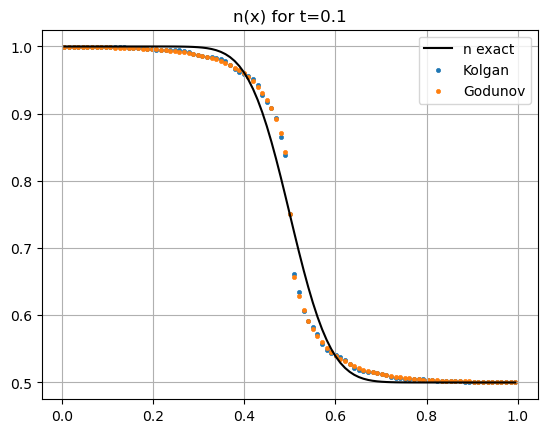

In [8]:
plt.title('n(x) for t=' + str(t_max))
plt.plot(x[:-1]+h/2, n_accurate(x[:-1]+h/2, t_max), label="n exact", color='black')


plt.scatter(x[:-1]+h/2, n_Kolgan, label="Kolgan", marker='.', linewidth=0.5)
#plt.scatter(x[:-1]+h/2, n_RK, label="Kolgan+RK", marker='.', linewidth=0.5)
plt.scatter(x[:-1]+h/2, n_God, label="Godunov", marker='.', linewidth=0.5)

plt.grid()
plt.legend()

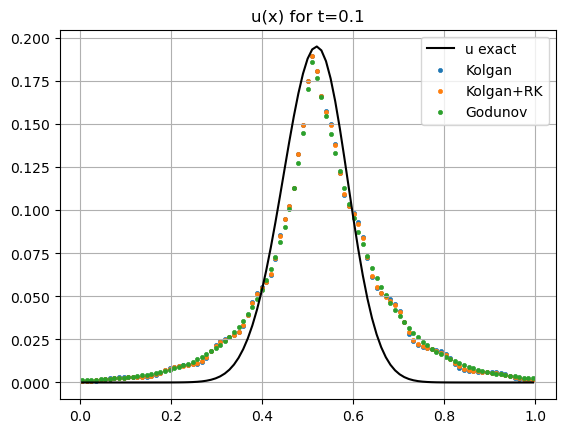

In [9]:
plt.title('u(x) for t=' + str(t_max))
plt.plot(x[:-1]+h/2, u_accurate(x[:-1]+h/2, t_max), label="u exact", color='black')


plt.scatter(x[:-1]+h/2, u_Kolgan, label="Kolgan", marker='.', linewidth=0.5)
plt.scatter(x[:-1]+h/2, u_RK, label="Kolgan+RK", marker='.', linewidth=0.5)
plt.scatter(x[:-1]+h/2, u_God, label="Godunov", marker='.', linewidth=0.5)


plt.grid()
plt.legend()

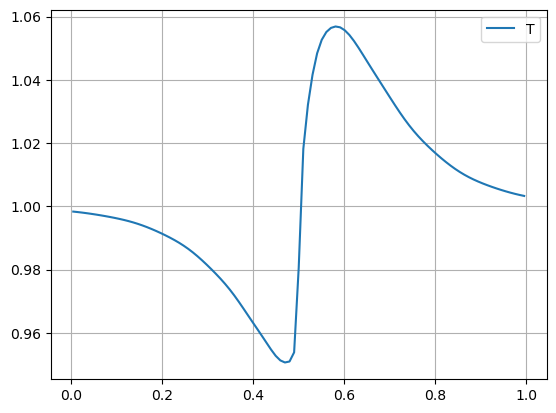

In [10]:
plt.plot(x[:-1]+h/2, T_God, label="T")
plt.grid()
plt.legend()